# Credal Sets 101 (for Probly): from “one probability” to “a set of probabilities”

This notebook is a practical introduction to **credal sets** for ML-oriented uncertainty representation, with a focus on what we can implement in `src.probly.representation.credal_set.array.py`.

**Core idea:** instead of predicting a single probability vector `p`, we predict a **set of plausible probability vectors** `Q`.  
This is a way to represent **epistemic uncertainty** (lack of knowledge) on top of **aleatoric uncertainty** (randomness in the world).

---

## 1) Why credal sets (in ML terms)

A standard probabilistic classifier outputs a distribution `p(y | x)` (a point in the probability simplex).  
That captures **aleatoric uncertainty**: class ambiguity/noise.

But if the model itself is uncertain (limited data, parameter uncertainty, conflicting predictors), a single sharp probability vector is overconfident.  
Credal sets represent **uncertainty about the probability** itself: `Q(x) ⊆ Δ`, i.e., multiple candidate distributions are plausible.

A sanity check:
- “Total ignorance” is not “uniform probability”.
- It is “any distribution could be true”, i.e. the *entire simplex*.

---

## 2) Minimal definitions

Let `Y = {1, …, C}` be `C` classes.

### 2.1 Probability simplex
A categorical distribution is a vector:
- `p ∈ R^C`
- `p_k ≥ 0`
- `Σ_k p_k = 1`

The set of all such `p` is the simplex `Δ^{C-1}`.

### 2.2 Credal set
A **credal set** is a (typically convex) subset `Q ⊆ Δ^{C-1}`.

In binary classification (`C=2`), many credal sets can be represented as an interval:
- `p(y=1) ∈ [a, b]` (then `p(y=0) = 1 - p(y=1)`)

---

## 3) The most implementable MVP: interval credal sets (lower/upper bounds)

A very practical credal-set representation is **probability intervals**:
- For each class `k`, we store bounds: `p_k ∈ [L_k, U_k]`

This defines a convex set:
`Q = { p ∈ Δ^{C-1} : L_k ≤ p_k ≤ U_k for all k }`

Non-emptiness constraint:
`Σ_k L_k ≤ 1 ≤ Σ_k U_k`

In code terms:
- `lower`: shape `(..., C)`
- `upper`: shape `(..., C)`
- validate: `0≤lower≤upper≤1` and `sum(lower)≤1≤sum(upper)`

---

## 4) Constructing interval credal sets from sampled predictors (the “credal wrapper” idea)

Suppose we have `N` sampled probability vectors from e.g. a deep ensemble or Bayesian sampling:
`p^(1), …, p^(N)`, each in `Δ^{C-1}`.

A simple construction:
- `L_k = min_n p^(n)_k`
- `U_k = max_n p^(n)_k`

This yields interval bounds per class and induces a credal set.

> **Note (important in practice):** The coordinate-wise `min/max` construction is a **conservative outer bound** and can be **very sensitive to outliers** (e.g., a single broken ensemble member or a rare MC-dropout sample can blow up an interval).
>
> If you want a more robust bound, you can replace `min/max` with **quantile bounds** (e.g. 5%–95%).  
> Caveat: coordinate-wise quantiles may **not** guarantee non-emptiness (`sum(upper) ≥ 1` and `sum(lower) ≤ 1`) in every case, so it is best used together with validation/fallback.



### 4.1 Code: bounds from samples + validation


In [1]:
from __future__ import annotations

from typing import Literal

import numpy as np

Method = Literal["minmax", "quantile"]


class UnknownMethodError(ValueError):
    """Raised when an unknown bounds construction method is requested."""


class InvalidCredalIntervalError(ValueError):
    """Raised when (lower, upper) does not define a non-empty interval credal set."""


def bounds_from_samples(
    samples: np.ndarray,
    method: Method = "minmax",
    q_low: float = 0.05,
    q_high: float = 0.95,
) -> tuple[np.ndarray, np.ndarray]:
    """Construct per-class lower/upper probability bounds from sampled probability vectors.

    Parameters
    ----------
    samples:
        Array of shape (N, ..., C), each slice along axis=0 is a probability vector.
    method:
        "minmax" uses min/max over samples; "quantile" uses quantiles.
    q_low, q_high:
        Quantiles used when method="quantile".

    Returns:
    -------
    (lower, upper):
        Arrays of shape (..., C).
    """
    if method == "minmax":
        lower = samples.min(axis=0)
        upper = samples.max(axis=0)
        return lower, upper

    if method == "quantile":
        lower = np.quantile(samples, q_low, axis=0)
        upper = np.quantile(samples, q_high, axis=0)
        return lower, upper

    msg = f"Unknown method: {method!r}"
    raise UnknownMethodError(msg)


def validate_interval_credal(
    lower: np.ndarray,
    upper: np.ndarray,
    tol: float = 1e-8,
) -> bool:
    """Validate that bounds define a non-empty interval credal set.

    Conditions:
    - 0 <= lower <= upper <= 1
    - sum(lower) <= 1 <= sum(upper)

    Returns True if valid; otherwise raises InvalidCredalIntervalError.
    """
    if lower.shape != upper.shape:
        msg = "lower/upper shape mismatch"
        raise InvalidCredalIntervalError(msg)

    if np.any(lower < -tol):
        msg = "lower has negatives"
        raise InvalidCredalIntervalError(msg)

    if np.any(upper > 1.0 + tol):
        msg = "upper exceeds 1"
        raise InvalidCredalIntervalError(msg)

    if np.any(lower > upper + tol):
        msg = "lower > upper somewhere"
        raise InvalidCredalIntervalError(msg)

    sl = lower.sum(axis=-1)
    su = upper.sum(axis=-1)

    if np.any(sl > 1.0 + tol):
        msg = "sum(lower) must be <= 1"
        raise InvalidCredalIntervalError(msg)

    if np.any(su < 1.0 - tol):
        msg = "sum(upper) must be >= 1"
        raise InvalidCredalIntervalError(msg)

    return True


def bounds_from_samples_safe(
    samples: np.ndarray,
    method: Method = "minmax",
    q_low: float = 0.05,
    q_high: float = 0.95,
    tol: float = 1e-8,
) -> tuple[np.ndarray, np.ndarray]:
    """Construct bounds and ensure they define a non-empty interval credal set.

    Falls back to "minmax" if the chosen method produces invalid bounds.
    """
    lower, upper = bounds_from_samples(samples, method=method, q_low=q_low, q_high=q_high)

    try:
        validate_interval_credal(lower, upper, tol=tol)
    except InvalidCredalIntervalError:
        lower, upper = bounds_from_samples(samples, method="minmax", q_low=q_low, q_high=q_high)
        validate_interval_credal(lower, upper, tol=tol)

    return lower, upper

In [2]:
rng = np.random.default_rng(0)
samples = rng.dirichlet(np.ones(3), size=500)
lower, upper = bounds_from_samples_safe(samples, method="quantile")

In [3]:
validate_interval_credal(lower, upper)

True

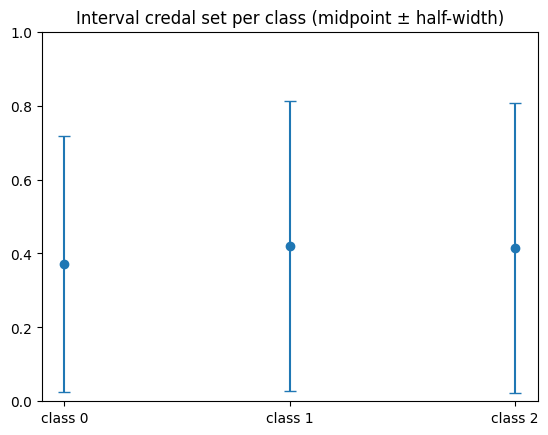

In [4]:
import matplotlib.pyplot as plt

C = lower.shape[-1]
x = np.arange(C)

mid = 0.5 * (lower + upper)
half_width = 0.5 * (upper - lower)

plt.figure()
plt.errorbar(x, mid, yerr=half_width, fmt="o", capsize=4)
plt.xticks(x, [f"class {i}" for i in range(C)])
plt.ylim(0, 1)
plt.title("Interval credal set per class (midpoint ± half-width)")
plt.show()

---

## 5) Mapping a credal set back to a single probability (optional but useful)

Sometimes downstream code expects a single probability vector.
> **Interpretation:** `p*` is just a **convenient representative point** inside the credal set (when it is non-empty), mainly to keep downstream pipelines working.  
> It is **not** a seeing-into-the-fabric-of-reality “true probability”, nor does it coincide (in general) with maximum-entropy, centroid, Bayesian posterior mean, etc.

One principled choice used in practice is an **intersection probability**:

`p* = lower + α (upper - lower)`

Choose `α` so that `Σ p*_k = 1`:
- If `den = Σ (upper - lower) > 0`
- then `α = (1 - Σ lower) / den`

Edge cases:
- If `upper == lower` everywhere, then the credal set is a point and `p* = lower`.

### 5.1 Code: intersection probability


In [5]:
import numpy as np


def intersection_probability(
    lower: np.ndarray,
    upper: np.ndarray,
    tol: float = 1e-12,
) -> np.ndarray:
    """Compute a representative probability vector inside the interval credal set.

    Uses p* = lower + alpha (upper - lower), choosing alpha so that sum(p*) = 1.
    """
    lower = np.asarray(lower)
    upper = np.asarray(upper)

    gap = upper - lower
    den = gap.sum(axis=-1, keepdims=True)
    num = 1.0 - lower.sum(axis=-1, keepdims=True)

    alpha = np.where(den > tol, num / den, 0.0)
    p_star = lower + alpha * gap

    p_star = np.clip(p_star, 0.0, 1.0)
    p_star = p_star / p_star.sum(axis=-1, keepdims=True)
    return p_star

---

## 6) Where do credal sets come from besides “sampling”? (robust statistics + evidence theory)

### 6.1 Robust frequentist view: ε-contamination

A classical robust model is ε-contamination:
`P = (1-ε) L + ε Q`, where `Q` can be any distribution.

Interpretation:
- `L` is the idealized likelihood model
- but we allow contamination by arbitrary noise/outliers.

For any event `A`, this implies:
- `P(A) = (1-ε)L(A) + ε Q(A)`
- so `P(A) ∈ [ (1-ε)L(A), (1-ε)L(A) + ε ]`

That’s literally an interval-valued probability assessment.

### 6.2 Multiple training sets → a credal set via convex hull + lower envelope

If we have multiple plausible likelihoods `L1, …, LN` (e.g. from different training sets),
we can build a credal set by contaminating each and taking the convex hull of their union.

A resulting lower envelope for events often has the form:
`L(A) = min_i (1-ε_i) L_i(A)`  
and the credal set is the set of all distributions dominating that lower bound.

### 6.3 Evidence theory / belief functions as lower probabilities

Belief functions assign mass to subsets of the sample space, not just singletons.
A belief function `Bel(A)` acts like a **lower probability bound** for every event `A`.

The induced credal set is:
`M(Bel) = {P : Bel(A) ≤ P(A) for all A}`

The corresponding upper probability is `Pl(A) = 1 - Bel(A^c)`.
For singletons, `pl(ω) = Pl({ω})` is called a contour function.

---

## 7) Uncertainty quantification (optional reading, but important to not fool ourselves)

Credal sets mix:
- set-based uncertainty (epistemic)
- probability-based uncertainty (aleatoric)

It’s tempting to “decompose” total uncertainty into epistemic + aleatoric by formulas,
but this can have technical and semantic issues.

Practical takeaway for implementation:
- store the representation cleanly (e.g., lower/upper)
- don’t overpromise on one magical scalar “uncertainty” unless we know what it means.

---

## 8) Implementation notes for `credal_set.array.py` (MVP)

**Suggested MVP class: `IntervalCredalSetArray`**

- **Data layout**
  - `lower`: shape `(..., C)` where the **last axis is classes**
  - `upper`: shape `(..., C)` same shape as `lower`
  - For stochastic predictors: `samples`: shape `(N, ..., C)` where `N` indexes ensemble / MC samples

- **Invariants (validate with tolerances)**
  - `0 ≤ lower ≤ upper ≤ 1`
  - `sum(lower, axis=-1) ≤ 1 ≤ sum(upper, axis=-1)` (non-emptiness)

- **Constructor / helpers**
  - `from_samples(samples, method="minmax" | "quantile", q=(...))`
    - if `method="quantile"`, recommend validate + fallback (see `bounds_from_samples_safe`)
  - `intersection_probability()` (returns shape `(..., C)` point probability)
  - `width()` = `upper - lower` (crude epistemic proxy)
  - `is_precise(tol=...)` when `max(abs(upper-lower)) ≤ tol`

**Not in MVP (expensive / future work):**
- convex hull / vertex enumeration (often infeasible for large `C`)
- full lower probability over all subsets `A ⊆ Y` (2^C blowup)

---

## 9) Summary

- Credal sets represent “a set of plausible probabilities” rather than a single vector.
- A very implementable representation is interval bounds per class.
- You can construct bounds from sampled predictors (ensembles / Bayesian sampling).
- You can map back to a point probability via intersection probability if needed.
- Robust stats and belief functions provide alternative motivations/derivations.


## 10) Minimal references

A short starting list (with pointers to what each reference is used for in this notebook):

- **Credal sets as a second-order formalism** (ignorance = full simplex), the basic “interval view” for classification, and the cautionary note that *additively* decomposing total uncertainty into aleatoric vs. epistemic can be conceptually problematic in the credal setting.  
  Hüllermeier, E., Destercke, S., & Shaker, M. H. (2022). *Quantification of Credal Uncertainty in Machine Learning: A Critical Analysis and Empirical Comparison.* In **UAI 2022**, PMLR 180, 548–557. 
- **Interval credal sets from finitely many sampled predictors** (lower/upper per class), the **intersection probability** mapping back to a single probability vector, and a practical note on why explicit convex-hull / vertex-based constructions do not scale nicely.  
  Wang, K., Cuzzolin, F., Shariatmadar, K., Moens, D., & Hallez, H. (2025). *Credal Wrapper of Model Averaging for Uncertainty Estimation in Classification.* **ICLR 2025**. 
  (Preprint / extended version: arXiv:2405.15047.) 

- **Foundations / broader modeling links**: robust frequentist **ε-contamination** as a credal set; constructing credal sets from multiple likelihoods via convex hull / lower envelope; belief functions as lower probabilities inducing credal sets; “core / natural extension” framing.  
  Caprio, M., Sultana, M., Elia, E. G., & Cuzzolin, F. (2024). *Credal Learning Theory.* arXiv:2402.00957v4.
